In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

%matplotlib inline

hour_result = pd.read_csv('../../model/output/check_hour.csv')
input_data = pd.read_csv('../../model/input/ricca_test_wind0.csv')

In [2]:
Rxleaf  = 1.838
Txleaf  = 34.7
Toleaf  = 20.57

# temp. function sum for veg. and rep. stage
# tempdvs = sumtemp/satVS or 1 + (sumtemp - satVS)/(satRS - satVS) or 2
satTemp   = 30       # requirement sum of temp_rate for flowering
satRep    = 150      # requirement sum of temp_rate for harvesting
optTemp   = 15.7       # max. temp for veg. and rep, growth, (temp_rate = np.exp(-1*(np.log(temp/optTemp)**2) )

# ver. function sum for vernalization
# verdvs = sumver / satVer or 1
satVer    = 52       # sum of ver_rate for flowering
optVer    = 6.2      # opt. temp. for vernalization , (verrate = np.exp(-1*(np.log(temp/optVer)**4) )

#timestep
time = 'hour'
conv = 1/24  if time == 'hour' else 1

In [3]:
dap = hour_result['dap'].tolist()

In [4]:
Ta = input_data['Tair'].tolist()


midRateLN (중간 단계 엽수)

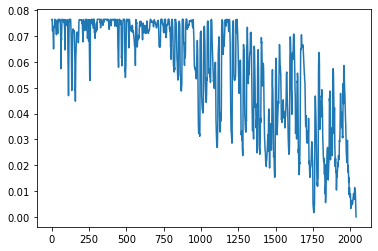

In [20]:
# calculation leaf number
midRateLN = []
for i in Ta:
    if (i > 0.0) and (i < Txleaf):
        leafrate = Rxleaf *((Txleaf-i)/(Txleaf-Toleaf))*(i/Toleaf)**(Toleaf/(Txleaf-Toleaf))
        leafrate = leafrate * conv
        midRateLN.append(leafrate)
    else:
        leafrate = 0.0
        midRateLN.append(leafrate)

plt.plot(midRateLN);

earlyRateLN (초기 단계 엽수)

In [6]:
earlyRateLN = []
for i in Ta:
    for x in midRateLN:
        earlyrateln = x * 0.05
        earlyRateLN.append(earlyrateln)

leafnumber

In [7]:
daysRoot = 10
pLeafForm = 0.69
inleafnumber = 6

leafnumbers = []
LN = []

for i in range(len(dap)):
    if dap[i] < daysRoot:
        leafrates = earlyRateLN[i]
        leafnumbers.append(leafrates)
    else:
        leafrates = midRateLN[i]*pLeafForm
        leafnumbers.append(leafrates)

for i in range(len(leafnumbers)):
    inleafnumber +=leafnumbers[i]
    LN.append(inleafnumber)

leafnumber = [int(x) for x in LN]

eachLenDist (엽 분포)

In [8]:
eachLenDist = []
for x in range(len(leafnumber)):
    number = []
    if leafnumber[x] < 8:                    ## limit of leafnumber 8장 보다 작을 경우 오류 방지
        for i in range(leafnumber[x]):
            number.append(1.0)
    else:
        a = 20.347*np.log(leafnumber[x]) - 40.703
        b = 0.2086*(leafnumber[x]) + 1.6862
        for i in range(1,leafnumber[x]+1):
            eachLen = a * np.exp(-0.5 * ((i - b) / b)**2)
            number.append(eachLen)
    eachLenDist.append(number)

eachLeafArea (엽 하나당 면적)

In [9]:
eachLeafArea = []
for i in range(len(eachLenDist)):
    eachleafarea = [0.3512*each**2 + 1.1328*each for each in eachLenDist[i]]
    eachLeafArea.append(eachleafarea)

eachLeafArea (엽 하나당 면적)

In [10]:
eachBladeArea = []
ratio = []
#
for i in range(len(eachLeafArea)):
    ratios = [0.9217*np.exp(-0.01*order) for order in range(1, len(eachLeafArea[i])+1)]
    ratio.append(ratios)


for x in range(len(ratio)):
    eachbladearea = [a*b for a, b in zip(ratio[x], eachLeafArea[x])]
    eachBladeArea.append(eachbladearea)

greenleaf 고려 X  전체 엽면적

In [11]:
LeafArea = []
for i in range(len(eachBladeArea)):
    leafarea = sum(eachBladeArea[i])
    LeafArea.append(leafarea)

greenleaf 고려 X  전체 LAI

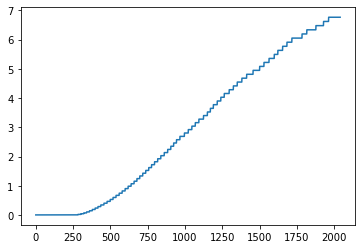

In [12]:
Lai = []

for i in range(len(LeafArea)):
    lai = LeafArea[i] * 3.8 / 10000
    Lai.append(lai)

plt.plot(Lai)
plt.show()

Green Leaf Area Cal

green leaf 갯수

In [13]:
numberGL = []
numberGreenLeaf = []

for i in range(len(eachBladeArea)):
    numbergl = 0.9333*np.exp(-0.017*len(eachBladeArea[i]))*len(eachBladeArea[i])
    numberGL.append(numbergl)
    numbergreenleaf = int(numberGL[i])
    numberGreenLeaf.append(numbergreenleaf)

green leaf 하나당 엽면적

In [14]:
greenBladeArea = []

for i in range(len(eachBladeArea)):
    greenbladearea = eachBladeArea[i][:numberGreenLeaf[i]]
    greenBladeArea.append(greenbladearea)

green leaf 총 엽면적

In [15]:
greenLeafArea = []
for i in range(len(greenBladeArea)):
    gleafarea = sum(greenBladeArea[i])
    greenLeafArea.append(gleafarea)

green leaf LAI

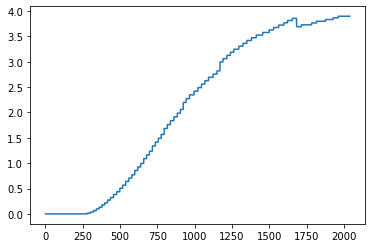

In [16]:
gLai = []

for i in range(len(greenLeafArea)):
    glai = greenLeafArea[i] * 3.8 / 10000
    gLai.append(glai)

plt.plot(gLai)
plt.show()

DVS

calcVerdvs

In [17]:
# optVer    = 6.2      # opt. temp. for vernalization , (verrate = np.exp(-1*(np.log(temp/optVer)**4) )
# satVer    = 52       # sum of ver_rate for flowering

tair = []
rate = []
sumVer = []
verdvs = []

for i in range(len(Ta)):
    ta = max(Ta[i], 0.01)
    tair.append(ta)

for i in range(len(tair)):
    rates = np.exp(-1*(np.log(tair[i]/optVer)**4))
    rate.append(rates)

for i in range(len(rate)):
    sumver = rate[i] * conv
    sumVer.append(sumver)

for i in range(len(sumVer)):
    verdvss = max(1, sumVer[i]/satVer)
    verdvs.append(verdvss)

calcTempdvs

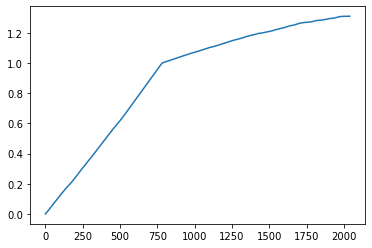

In [18]:
# optTemp   = 15.7       # max. temp for veg. and rep, growth, (temp_rate = np.exp(-1*(np.log(temp/optTemp)**2) )

rateT = []
sumtemp = 0
sumTemp = []
tempdvs = []


for i in range(len(tair)):
    ratet = np.exp(-1*(np.log(tair[i]/optTemp)**2))
    rateT.append(ratet)

for i in range(len(rateT)):
    sumtemp += rateT[i] * conv
    sumTemp.append(sumtemp)

    if sumTemp[i] >= satRep:
        tempdvss = 2.0
        tempdvs.append(tempdvss)
    elif sumTemp[i] > satTemp:
        tempdvss = 1 + (sumTemp[i] - satTemp) /(satRep - satTemp)
        tempdvs.append(tempdvss)
    else:
        tempdvss = sumTemp[i] / satTemp
        tempdvs.append(tempdvss)
# tempdvs
plt.plot(tempdvs);

dvs

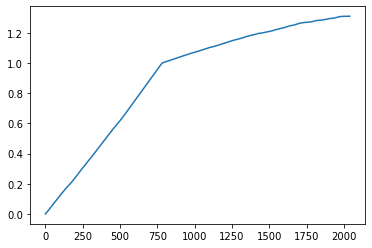

In [19]:
DVS = []

for i in range(len(verdvs)):
    dvs = verdvs[i] * tempdvs[i]
    DVS.append(dvs)
# DVS
plt.plot(DVS);